In [1]:
%matplotlib inline
from desc.equilibrium import EquilibriaFamily
from desc.plotting import plot_surfaces
from desc.objectives import MagneticWell
from desc.grid import LinearGrid
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

DESC version 0.4.13+568.g45be54d.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 10.62 GB available memory


In [2]:
class MagneticWellVisual:
    # to print and plot more (less) quantities, add (remove) them to the dict
    # returned from MagneticWell.compute() and self.st and data_variables
    # everything else is automatic

    X = 0  # index of coordinate tuple (x_pts, y_pts)
    Y = 1  # index of coordinate tuple (x_pts, y_pts)
    data_variables = "V", "p_r"  # list of keys to plot returned in data dict

    def __init__(
        self,
        name,
        has_stellopt_data=False,
        use_stellopt_rho=False,
        rho=np.linspace(1 / 30, 1, 30),
    ):
        self.name = name
        # collect final equilibrium
        self.eq = EquilibriaFamily.load(
            load_from="examples/DESC/" + name + "_output.h5"
        )[-1]
        self.st = dict()  # values are tuples of (x[i], y[i]) of plotable data

        if has_stellopt_data:
            # pull stellopt data from matlab .mat file
            mat = sio.loadmat("magwell-data/" + name + "_magwell.mat")
            self.st["STELLOPT Magnetic Well"] = mat["rho"], mat["magwell"]
            if use_stellopt_rho:
                rho = mat["rho"]

        # y points are cached when compute_plot() is called
        self.rho = rho
        self.st["DESC Magnetic Well"] = rho, np.empty(len(rho))
        self.st["V surface integral"] = rho, np.empty(len(rho))
        self.st["V"] = rho, np.empty(len(rho))
        self.st["dv_drho"] = rho, np.empty(len(rho))
        self.st["pressure_average"] = rho, np.empty(len(rho))
        self.st["Bsquare_average"] = rho, np.empty(len(rho))
        self.st["p_r"] = rho, np.empty(len(rho))

    def print_values(self, grid=None, print_stellopt=False):
        # prints what is returned by MagneticWell.compute()
        # the default grid=None uses the rho=1 flux surface
        # the volume enclosed by the rho=1 surface should match data["V"],
        # the entire volume, but it doesn't

        m = MagneticWell(eq=self.eq, grid=grid).compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.p_l,
            self.eq.i_l,
            self.eq.Psi,
        )
        print(self.name)
        print(self.eq)
        for key, val in m.items():
            if key == "data":
                for var in MagneticWellVisual.data_variables:
                    print('{0}["{1}"] {2}'.format(key, var, val[var]))
            else:
                print(key, val)

        if print_stellopt and (s := "STELLOPT Magnetic Well") in self.st:
            pts = self.st[s]
            print(s)
            for i in range(len(pts[MagneticWellVisual.X])):
                print(pts[MagneticWellVisual.X][i], pts[MagneticWellVisual.Y][i])
        print()

    def compute_plot(self):
        # compute and cache MagneticWell.compute() values
        # for the given array of rho=constant surfaces

        for i in range(len(self.rho)):
            grid = LinearGrid(
                L=1,
                M=2 * self.eq.M_grid + 10,
                N=2 * self.eq.N_grid + 10,
                NFP=self.eq.NFP,
                sym=self.eq.sym,
                rho=self.rho[i],
            )
            m = MagneticWell(eq=self.eq, grid=grid).compute(
                self.eq.R_lmn,
                self.eq.Z_lmn,
                self.eq.L_lmn,
                self.eq.p_l,
                self.eq.i_l,
                self.eq.Psi,
            )
            assert m["check_derivs_B_r"] and m["check_derivs_p_r"]
            # cache computed quantity in the y coordinate array
            for key, val in m.items():
                if key == "data":
                    for var in MagneticWellVisual.data_variables:
                        # for arrays like "p_r" just get first element
                        y = val[var][0] if val[var].ndim > 0 else val[var]
                        self.st[var][MagneticWellVisual.Y][i] = y
                else:
                    # don't want to plot check_derivs keys used in assertions
                    if key in self.st:
                        self.st[key][MagneticWellVisual.Y][i] = val

            self.st["W * p_r[0] / dv_drho"] = (
                self.rho,
                self.st["DESC Magnetic Well"][MagneticWellVisual.Y]
                * self.st["p_r"][MagneticWellVisual.Y]
                / self.st["dv_drho"][MagneticWellVisual.Y],
            )

    def plot(self, width=6, height=6, scatter=True):
        # plot all quantities cached from compute_plot()
        # and STELLOPT data if it exists

        fig, ax = plt.subplots(ncols=len(self.st))
        fig.set_size_inches(len(self.st) * width, height)

        i = 0
        for key, val in self.st.items():
            x = val[MagneticWellVisual.X]
            y = val[MagneticWellVisual.Y]
            if scatter:
                ax[i].scatter(x, y)
            ax[i].plot(x, y)
            ax[i].set(xlabel="rho")
            ax[i].set_title(self.name + ": " + key)
            i += 1

In [3]:
dshape = MagneticWellVisual(
    "DSHAPE", has_stellopt_data=True, use_stellopt_rho=False
)
heliotron = MagneticWellVisual(
    "HELIOTRON", has_stellopt_data=True, use_stellopt_rho=False
)
axisym = MagneticWellVisual("AXISYM", has_stellopt_data=False)

In [4]:
# just to make sure equilibrium were solved correctly on my computer
# plot_surfaces(dshape.eq)
# plot_surfaces(heliotron.eq)
# plot_surfaces(axisym.eq)

In [5]:
dshape.print_values()
heliotron.print_values()
axisym.print_values()

DSHAPE
Equilibrium at 0x7f27881cf3d0 (L=26, M=13, N=0, NFP=1.0, sym=1, spectral_indexing=fringe)
Bsquare_average 0.05766179166752265
DESC Magnetic Well [0.10346503]
V surface integral 77.2858274674659
check_derivs_B_r True
check_derivs_p_r True
data["V"] 168.593195468514
data["p_r"] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [6]:
dshape.compute_plot()
heliotron.compute_plot()
axisym.compute_plot()

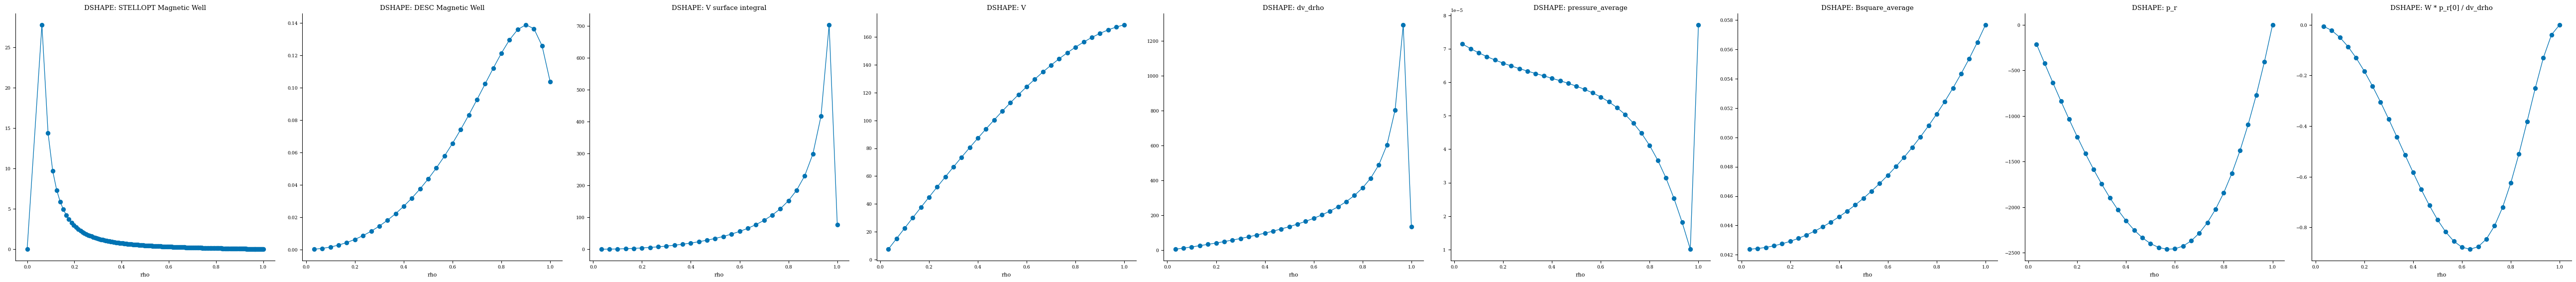

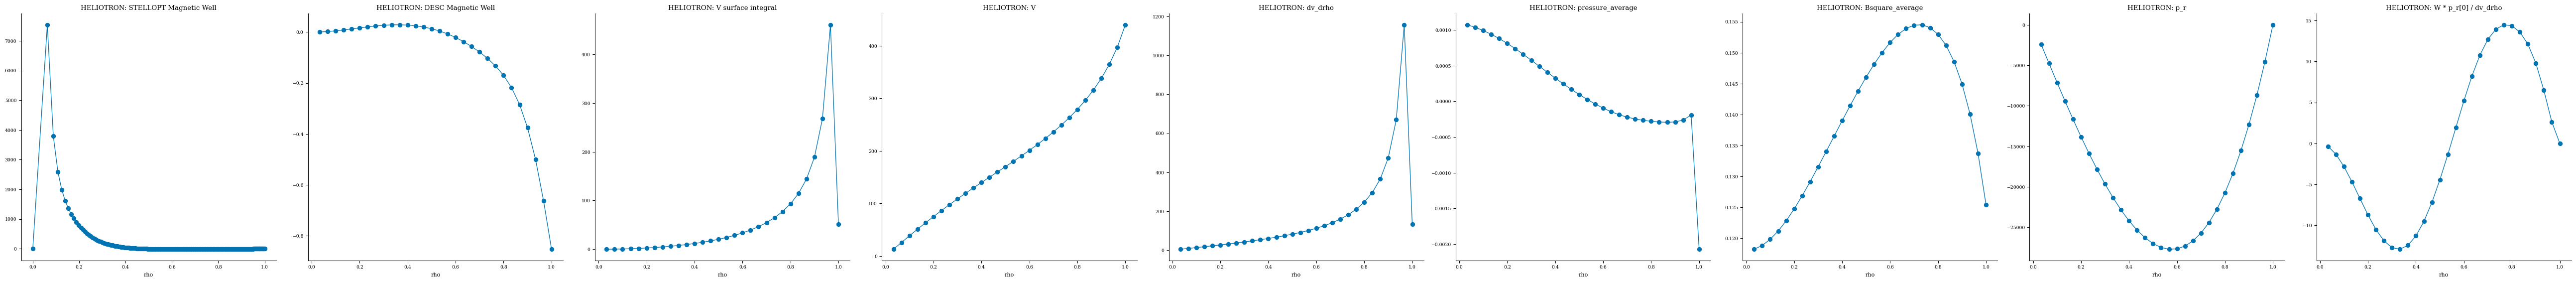

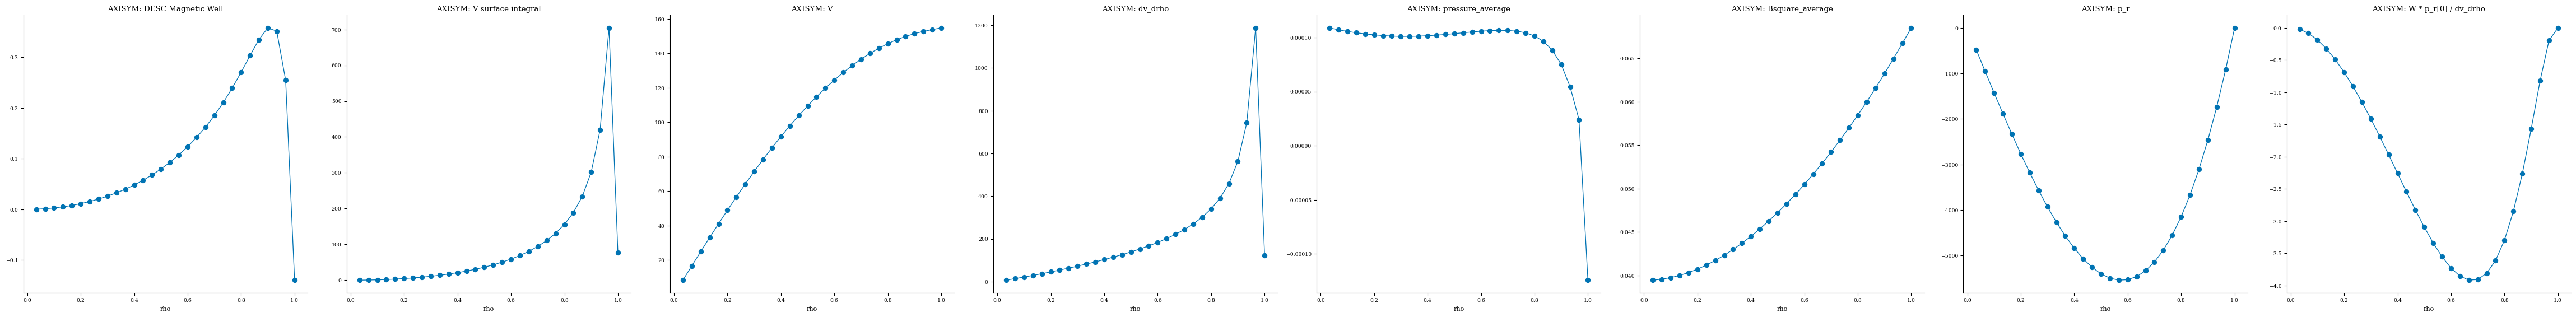

In [7]:
dshape.plot()
heliotron.plot()
axisym.plot()

![DSHAPE_magwell.png](magwell-data/DSHAPE_magwell.png)

![HELIOTRON_magwell.png](magwell-data/HELIOTRON_magwell.png)

In [8]:
# is the surface still rho=constant when an array is given into grid?
grid = LinearGrid(
    M=2 * dshape.eq.M_grid + 10,
    N=2 * dshape.eq.N_grid + 10,
    NFP=dshape.eq.NFP,
    sym=dshape.eq.sym,
    rho=dshape.rho,
)
dshape.print_values(grid)

DSHAPE
Equilibrium at 0x7f27881cf3d0 (L=26, M=13, N=0, NFP=1.0, sym=1, spectral_indexing=fringe)
Bsquare_average 0.04951200278430181
DESC Magnetic Well [0.07487071]
V surface integral 875.5573999295605
check_derivs_B_r True
check_derivs_p_r True
data["V"] 102.04053197067944
data["p_r"] [-213.0962963 -213.0962963 -213.0962963 ...    0.           0.
    0.       ]
dv_drho 2511.6680219273408
pressure_average 4.233872959810548e-06

